# Revisiting error propagation with automatic differentiation

By Kyle Cranmer, March 2, 2020

This notebook is dedicated to Feeman Dyson, who died on February 28, 2020 in Princeton, NJ at the age of 96.

“New directions in science are launched by new tools much more often than by new concepts. The effect of a concept-driven revolution is to explain old things in new ways. The effect of a tool-driven revolution is to discover new things that have to be explained.”

-- Freeman Dyson

![](https://www.ias.edu/sites/default/files/styles/grid_feature_teaser/public/Dyson_Freeman_Dyson_20151016_DKomoda-5376%20%281200%29.jpg?itok=oGwqWjL8![image.png](attachment:image.png))

## Reminder of propagation of errors 

This notebook was made to investigate the propagation of errors formula.
We imagine that we have a function $q(x,y)$ and we want to propagate the
uncertainty on $x$ and $y$ (denoted $\sigma_x$ and $\sigma_y$, respectively) through to the quantity $q$.

The most straight forward way to do this is just randomly sample $x$ and $y$, evaluate $q$ and look at it's distribution. This is really the definition of what we mean by propagation of uncertianty. It's very easy to do with some simply python code.

The calculus formula for the propagation of errors is really an approximation. This is the formula for a general $q(x,y)$
\begin{equation}
\sigma_q^2 = \left( \frac{\partial q}{\partial x} \sigma_x \right)^2 + \left( \frac{\partial q}{\partial y}\sigma_y \right)^2
\end{equation}

In the special case of addition  $q(x,y) = x\pm y$ we have $\sigma_q^2 = \sigma_x^2 + \sigma_y^2$.

In the special case of multiplication $q(x,y) = x y$ and division $q(x,y) = x / y$ we have $(\sigma_q/q)^2 = (\sigma_x/x)^2 + (\sigma_y/y)^2$, which we can rewrite as $\sigma_q = (x/y) \sqrt{(\sigma_x/x)^2 + (\sigma_y/y)^2}$

Let's try out these formulas and compare the direct approach of making the distribution to the prediction from these formulas

## Automatic Differentiation



Excerpts from the Wikipedia article: https://en.wikipedia.org/wiki/Automatic_differentiation

In mathematics and computer algebra, automatic differentiation (AD), also called algorithmic differentiation or computational differentiation,[1][2] is a set of techniques to numerically evaluate the derivative of a function specified by a computer program. AD exploits the fact that every computer program, no matter how complicated, executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.). By applying the chain rule repeatedly to these operations, derivatives of arbitrary order can be computed automatically, accurately to working precision, and using at most a small constant factor more arithmetic operations than the original program.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/AutomaticDifferentiationNutshell.png/600px-AutomaticDifferentiationNutshell.png)

Usually, two distinct modes of AD are presented, forward accumulation (or forward mode) and reverse accumulation (or reverse mode). Forward accumulation specifies that one traverses the chain rule from inside to outside (that is, first compute 
${\displaystyle dw_{1}/dx}$ and then 
${\displaystyle dw_{2}/dw_{1}}$ and at last 
${\displaystyle dy/dw_{2}})$, while reverse accumulation has the traversal from outside to inside (first compute 
${\displaystyle dy/dw_{2}}$ and then 
${\displaystyle dw_{2}/dw_{1}}$ and at last 
${\displaystyle dw_{1}/dx})$. More succinctly,

 * forward accumulation computes the recursive relation: 
${\displaystyle {\frac {dw_{i}}{dx}}={\frac {dw_{i}}{dw_{i-1}}}{\frac {dw_{i-1}}{dx}}}$ with 
${\displaystyle w_{3}=y}$, and,

 * reverse accumulation computes the recursive relation: 
${\displaystyle {\frac {dy}{dw_{i}}}={\frac {dy}{dw_{i+1}}}{\frac {dw_{i+1}}{dw_{i}}}}$ with 
${\displaystyle w_{0}=x}$.

<!--


Fundamental to AD is the decomposition of differentials provided by the chain rule. For the simple composition


\begin{equation}
{\displaystyle {\begin{aligned}y&=f(g(h(x)))=f(g(h(w_{0})))=f(g(w_{1}))=f(w_{2})=w_{3}\\w_{0}&=x\\w_{1}&=h(w_{0})\\w_{2}&=g(w_{1})\\w_{3}&=f(w_{2})=y\end{aligned}}}
\end{equation}
the chain rule gives

\begin{equation}
{\displaystyle {\frac {dy}{dx}}={\frac {dy}{dw_{2}}}{\frac {dw_{2}}{dw_{1}}}{\frac {dw_{1}}{dx}}}
\end{equation}
Usually, two distinct modes of AD are presented, forward accumulation (or forward mode) and reverse accumulation (or reverse mode). Forward accumulation specifies that one traverses the chain rule from inside to outside (that is, first compute ${\displaystyle dw_{1}/dx}$ and then 
${\displaystyle dw_{2}/dw_{1}}$ and at last 
${\displaystyle dy/dw_{2}})$, while reverse accumulation has the traversal from outside to inside (first compute 
${\displaystyle dy/dw_{2}}$ and then 
${\displaystyle dw_{2}/dw_{1}}$ and at last 
${\displaystyle dw_{1}/dx})$. More succinctly,
forward accumulation computes the recursive relation: 

\begin{equation}
{\displaystyle {\frac {dw_{i}}{dx}}={\frac {dw_{i}}{dw_{i-1}}}{\frac {dw_{i-1}}{dx}}} 
\end{equation}
with 
${\displaystyle w_{3}=y}$, and,
reverse accumulation computes the recursive relation: 

\begin{equation}
{\displaystyle {\frac {dy}{dw_{i}}}={\frac {dy}{dw_{i+1}}}{\frac {dw_{i+1}}{dw_{i}}}}
\end{equation}
with ${\displaystyle w_{0}=x}$.
Generally, both forward and reverse accumulation are specific manifestations of applying the operator of program composition, fixing the appropriate one of the two mappings 

\begin{equation}
{\displaystyle (w,y)}.
\end{equation}

### Forward mode

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/ForwardAccumulationAutomaticDifferentiation.png/600px-ForwardAccumulationAutomaticDifferentiation.png)

In forward accumulation AD, one first fixes the independent variable with respect to which differentiation is performed and computes the derivative of each sub-expression recursively. In a pen-and-paper calculation, this involves repeatedly substituting the derivative of the inner functions in the chain rule:

\begin{equation}
{\displaystyle {\frac {\partial y}{\partial x}}={\frac {\partial y}{\partial w_{n-1}}}{\frac {\partial w_{n-1}}{\partial x}}={\frac {\partial y}{\partial w_{n-1}}}\left({\frac {\partial w_{n-1}}{\partial w_{n-2}}}{\frac {\partial w_{n-2}}{\partial x}}\right)={\frac {\partial y}{\partial w_{n-1}}}\left({\frac {\partial w_{n-1}}{\partial w_{n-2}}}\left({\frac {\partial w_{n-2}}{\partial w_{n-3}}}{\frac {\partial w_{n-3}}{\partial x}}\right)\right)=\cdots }
\end{equation}
This can be generalized to multiple variables as a matrix product of Jacobians.


### Reverse mode

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/ReverseaccumulationAD.png/600px-ReverseaccumulationAD.png)

In reverse accumulation AD, the dependent variable to be differentiated is fixed and the derivative is computed with respect to each sub-expression recursively. In a pen-and-paper calculation, the derivative of the outer functions is repeatedly substituted in the chain rule:

\begin{equation}
{\frac  {\partial y}{\partial x}}={\frac  {\partial y}{\partial w_{1}}}{\frac  {\partial w_{1}}{\partial x}}=\left({\frac  {\partial y}{\partial w_{2}}}{\frac  {\partial w_{2}}{\partial w_{1}}}\right){\frac  {\partial w_{1}}{\partial x}}=\left(\left({\frac  {\partial y}{\partial w_{3}}}{\frac  {\partial w_{3}}{\partial w_{2}}}\right){\frac  {\partial w_{2}}{\partial w_{1}}}\right){\frac  {\partial w_{1}}{\partial x}}=\cdots 
\end{equation}

-->


We will use 
https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html

In [1]:
from jax import grad, jacfwd
import jax.numpy as np

Now here are 3 lines of code for the propagation of uncertainty formula

\begin{equation}
\sigma_q = \sqrt{\left( \frac{\partial q}{\partial x} \sigma_x \right)^2 + \left( \frac{\partial q}{\partial y}\sigma_y \right)^2}
\end{equation}

In [2]:
def error_prop_jax_gen(q,x,dx):
    jac = jacfwd(q)
    return np.sqrt(np.sum(np.power(jac(x)*dx,2)))

## Setup two observations with uncertainties

Below I'll use $x$ and $y$ for symbols, but they will be stored in the array `x` so that `x[0]=`$x$ and `x[1]=$y$.

In [3]:
x_ = np.array([2.,3.])
dx_ = np.array([.1,.1])

/Users/cranmer/anaconda3/envs/jax-md/lib/python3.6/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Addition and Subtraction


In the special case of addition  $q(x,y) = x\pm y$ we have $\sigma_q^2 = \sigma_x^2 + \sigma_y^2$.


In [4]:
def q(x):
    return x[0]+x[1]

In [5]:
def error_prop_classic(x, dx):
    # for q = x[0]*x[1]
    ret = dx[0]**2 + dx[1]**2
    return np.sqrt(ret)

In [6]:
print('q = ', q(x_), '+/-', error_prop_classic(x_, dx_))

q =  5.0 +/- 0.14142136


In [7]:
print('q = ', q(x_), '+/-', error_prop_jax_gen(q, x_, dx_))

q =  5.0 +/- 0.14142136


## Multiplication and Division

In the special case of multiplication 
\begin{equation}
q(x,y) = x y
\end{equation}
and division 
\begin{equation}
q(x,y) = \frac{x}{y}
\end{equation}

\begin{equation}
(\sigma_q/q)^2 = (\sigma_x/x)^2 + (\sigma_y/y)^2
\end{equation}
which we can rewrite as
\begin{equation}
\sigma_q = (x/y) \sqrt{\left(\frac{\sigma_x}{x}\right)^2 + \left(\frac{\sigma_y}{y}\right)^2}
\end{equation}

In [8]:
def q(x):
    return x[0]*x[1]

In [9]:
def error_prop_classic(x, dx):
    # for q = x[0]*x[1]
    ret = (dx[0]/x[0])**2 + (dx[1]/x[1])**2 
    return (x[0]*x[1])*np.sqrt(ret)

In [10]:
print('q = ', q(x_), '+/-', error_prop_classic(x_, dx_))

q =  6.0 +/- 0.36055514


In [11]:
print('q = ', q(x_), '+/-', error_prop_jax_gen(q, x_, dx_))

q =  6.0 +/- 0.36055514


In [12]:
def q(x):
    return x[0]/x[1]

In [13]:
def error_prop_classic(x, dx):
    # for q = x[0]*x[1]
    ret = (dx[0]/x[0])**2 + (dx[1]/x[1])**2 
    return (x[0]/x[1])*np.sqrt(ret)

In [14]:
print('q = ', q(x_), '+/-', error_prop_classic(x_, dx_))

q =  0.6666667 +/- 0.040061682


In [15]:
print('q = ', q(x_), '+/-', error_prop_jax_gen(q, x_, dx_))

q =  0.6666667 +/- 0.040061682


## Powers

$q(x,y) = x^m y^n$ 
we have 

\begin{equation}
(\sigma_q/q)^2 = \left(|m|\frac{\sigma_x}{x}\right)^2 + \left(|n|\frac{\sigma_y}{y}\right)^2
\end{equation}
which we can rewrite as 
\begin{equation}
\sigma_q = x^m y^n \sqrt{\left(|m|\frac{\sigma_x}{x}\right)^2 + \left(|n|\frac{\sigma_y}{y}\right)^2}
\end{equation}


In [16]:
def q(x, m=2, n=3):
    return np.power(x[0],m)*np.power(x[1],n)

In [17]:
x_ = np.array([1.5, 2.5])
dx_ = np.array([.1, .1])
q(x_)

DeviceArray(35.15625, dtype=float32)

In [18]:
def error_prop_classic(x, dx):
    # for q = x[0]*x[1]
    dq_ = q(x_)*np.sqrt(np.power(2*dx_[0]/x_[0],2)+np.power(3*dx_[1]/x_[1],2))
    return dq_

In [19]:
print('q = ', q(x_), '+/-', error_prop_classic(x_, dx_))

q =  35.15625 +/- 6.3063865


In [20]:
print('q = ', q(x_), '+/-', error_prop_jax_gen(q, x_, dx_))

q =  35.15625 +/- 6.3063865


## Misc Examples

See some examples here:

http://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html



Example:  `w = (4.52 ± 0.02) cm, A = (2.0 ± 0.2), y = (3.0 ± 0.6) cm`. Find

\begin{equation}
z=\frac{wy^2}{\sqrt{A}}
\end{equation}

The second relative error, (Dy/y), is multiplied by 2 because the power of y is 2.  
The third relative error, (DA/A), is multiplied by 0.5 since a square root is a power of one half.

So Dz = 0.49 (28.638  ) = 14.03  which we round to 14 

z = (29 ± 14) 
Using Eq. 3b, 
z=(29 ± 12) 
Because the uncertainty begins with a 1, we keep two significant figures and round the answer to match.

In [21]:
def q(x):
    return x[0]*x[2]*x[2]/np.sqrt(x[1])

In [22]:
x_ = np.array([4.52, 2., 3.]) #w,A,y
dx_ = np.array([.02, .2, .6])

print('q = ', q(x_), '+/-', error_prop_jax_gen(q, x_, dx_))

q =  28.765104 +/- 11.596283


### Check with a plot

In [23]:
import numpy as onp  #using jax as np right now
w_ = onp.random.normal(x_[0], dx_[0], 10000)
A_ = onp.random.normal(x_[1], dx_[1], 10000)
y_ = onp.random.normal(x_[2], dx_[2], 10000)
x__ = np.vstack((w_, A_, y_))
z_ = q(x__)
print('mean =', np.mean(z_), 'std = ', np.std(z_))

mean = 30.050316 std =  11.813263


In [24]:
import matplotlib.pyplot as plt

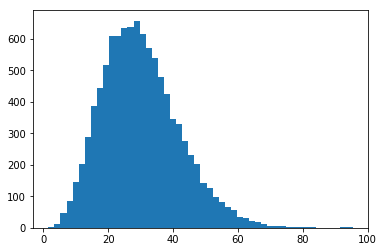

In [25]:
_ = plt.hist(z_, bins=50)

## Example 2

also taken from http://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html


`w = (4.52 ± 0.02) cm, x = (2.0 ± 0.2) cm, y = (3.0 ± 0.6) cm. `

Find 
\begin{equation}
z = w x +y^2
\end{equation}


We have v = wx = (9.0 ± 0.9) cm.  
The calculation of the uncertainty in  is the same as that shown to the left. Then from Eq. 1b 
Dz =  3.7  
z = (18 ± 4) . 

In [26]:
def q(x):
    # [w,x,y]
    return x[0]*x[1]+x[2]*x[2]

In [27]:
x_ = np.array([4.52, 2., 3.]) #w,x,y
dx_ = np.array([.02, .2, .6])

In [28]:
print(q(x_),'+/-', error_prop_jax_gen(q, x_, dx_))

18.04 +/- 3.711983


## An example with many inputs

The code we used for `error_prop_jax_gen` is generic and supports functions `q` on any number of variables

In [29]:
def q(x):
    return np.sum(x)

In [30]:
x_ = 1.*np.arange(1,101) #counts from 1-100 (and 1.* to make them floats)
dx_ = 0.1*np.ones(100)

The sum from $1 to N$ is $N*(N+1)/2$  (see [the story of Gauss](https://hsm.stackexchange.com/questions/384/did-gauss-find-the-formula-for-123-ldotsn-2n-1n-in-elementary-school)), so we expect q(x)=5050. And the uncertainty should be $\sqrt{100}*0.1$ = 1.

In [31]:
print(q(x_),'+/-', error_prop_jax_gen(q, x_, dx_))

5050.0 +/- 1.0


another toy example... product from 1 to 10

In [32]:
def q(x):
    return np.product(x)

In [33]:
x_ = 1.*np.arange(1,11) #counts from 1-100 (and 1.* to make them floats)
dx_ = 0.1*np.ones(10)
print(q(x_),'+/-', error_prop_jax_gen(q, x_, dx_))

3628800.0 +/- 451748.1


Checking this is an exercise left to the reader :-)